### Résulats

#### Partie 5 - Analyse des résultats et vérification du model


In [1]:
%matplotlib inline

import random
import numpy as np
import os
import sys
from IPython.display import display
import tensorflow as tf
import datetime
from keras import callbacks
from keras.models import load_model
tf.debugging.set_log_device_placement(False)
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(1)

sys.path.append('..')
import Modules.utils as utils
import Modules.init as init
import Modules.display as disp
import Modules.generator as gen
import Modules.model as model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

datasets_dir = init.init('U-NET analysis')

<br>**Projet M1 - Détection d'anomalies sur imagerie médicale - U-NET analysis**

Version              : 2
Notebook id          : U-NET analysis
Run time             : Monday 13 February 2023, 19:20:35
Hostname             : ludovic-ubu (Linux)
Tensorflow log level : Error only  (=2)
Datasets dir         : /media/ludovic/Cache/ENID
Run dir              : ./run
Update keras cache   : False
tensorflow           : 2.8.0
tensorflow.keras     : 2.8.0
numpy                : 1.21.5
skimage              : 0.19.2
matplotlib           : 3.5.1
pandas               : 1.3.5


In [7]:
seed=24
batch_size= 20

val_img_path = os.path.join(datasets_dir, 'DATASET', 'Validation', 'Images')
val_mask_path = os.path.join(datasets_dir, 'DATASET', 'Validation', 'Masks')
val_img_gen = gen.trainGenerator(val_img_path, val_mask_path, batch_size, seed)

model = load_model("ENDOMETRIOSIS_UNET_SEG_BC.hdf5", compile=False)

test_image_batch, test_mask_batch = val_img_gen.__next__()

Found 1244 images belonging to 1 classes.
Found 1244 images belonging to 1 classes.


In [57]:
y_pred=model.predict(test_image_batch)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_argmax = np.argmax(test_mask_batch, axis=3)

KeyboardInterrupt: 

In [ ]:
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 1.0


(384, 640, 3)
(384, 640, 1)
(1, 384, 640, 3)
(1, 384, 640, 1)
(384, 640, 1)


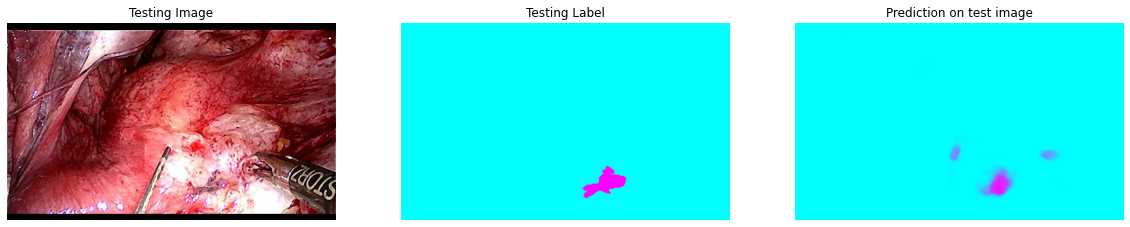

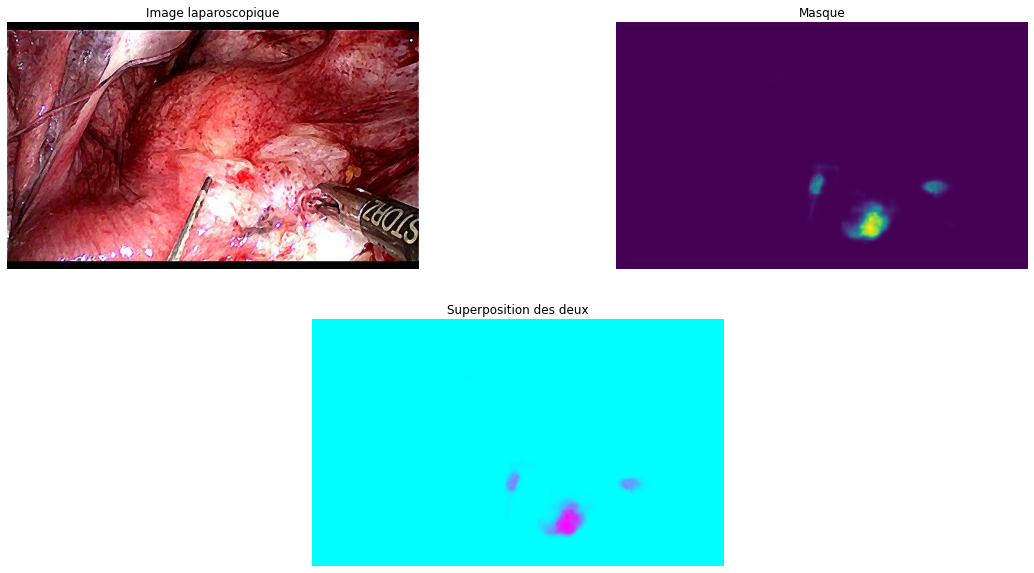

In [11]:
import matplotlib.pyplot as plt
test_image_batch, test_mask_batch = val_img_gen.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
print(test_img.shape)
ground_truth=test_mask_batch[test_img_number]
print(ground_truth.shape)

test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input))
print(prediction.shape)
predicted_img=np.reshape(prediction, (384, 640, 1))
print(predicted_img.shape)

plt.figure(figsize=(20, 15))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.axis('off')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='cool')
plt.axis('off')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='cool')
plt.axis('off')
plt.show()

disp.plot3(test_img, predicted_img)

In [5]:

os.path.join(os.curdir, 'tes')

'./tes'

In [3]:
import os
os.curdir

'.'